# Model WL Profiles (Object Oriented)

## Notebook for generating an example galaxy cluster model. 

This notebook goes through the steps to generate model data for galaxy cluster weak lensing observables.  In particular, we define a galaxy cluster model that follows and NFW distribution and generate various profiles for the model (mass density, convergence, shear, etc.), which we plot.  Note, a full pipeline to measure a galaxy cluster weak lensing mass requires fitting the observed (or mock) data to a model. In this notebook we use the OO interface to theory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Imports specific to clmm 

In [2]:
import os

os.environ[
    "CLMM_MODELING_BACKEND"
] = "ccl"  # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm import Cosmology

Make sure we know which version we're using

In [3]:
clmm.__version__

'1.12.3'

Define a cosmology using astropy

In [4]:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

Define the galaxy cluster model.  Here, we choose parameters that describe the galaxy cluster model, including the mass definition, concentration, and mass distribution.  For the mass distribution, we choose a distribution that follows an NFW profile.

In [5]:
moo = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="nfw")

moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(1.0e15)

z_cl = 1.0

# source properties
z_src = 2.0  # all sources in the same plane
z_distrib_func = clmm.redshift.distributions.chang2013  # sources redshift following a distribution
alpha = [2, -0.5]

Quick test of all theory functionality

In [6]:
r3d = np.logspace(-2, 2, 100)
rho = moo.eval_3d_density(r3d, z_cl)
Sigma = moo.eval_surface_density(r3d, z_cl)
Sigma_mis = moo.eval_surface_density(r3d, z_cl, r_mis=0.2)
DeltaSigma = moo.eval_excess_surface_density(r3d, z_cl)
gammat = moo.eval_tangential_shear(r3d, z_cl, z_src)
kappa = moo.eval_convergence(r3d, z_cl, z_src)

gt = moo.eval_reduced_tangential_shear(r3d, z_cl, z_src)
# Lensing quantities assuming sources follow a given redshift distribution.

# Compute first beta
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = clmm.utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = clmm.utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

gt_z = moo.eval_reduced_tangential_shear(
    r3d, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

mu = moo.eval_magnification(r3d, z_cl, z_src)
mu_bias = moo.eval_magnification_bias(r3d, z_cl, z_src, alpha)

/Users/jimmy/Repos/CLMM/clmm/theory/generic.py:66: UserWarning: Magnification is negative for certain radii,                     returning nan for magnification bias in this case.
  warnings.warn(
/Users/jimmy/Repos/CLMM/clmm/theory/generic.py:70: RuntimeWarning: invalid value encountered in power
  return np.array(magnification) ** (np.array([alpha]).T - 1)


Plot the predicted profiles

In [7]:
def plot_profile(r, profile_vals, profile_label="rho", label=""):
    plt.loglog(r, profile_vals, label=label)
    plt.xlabel("r [Mpc]", fontsize="xx-large")
    plt.ylabel(profile_label, fontsize="xx-large")

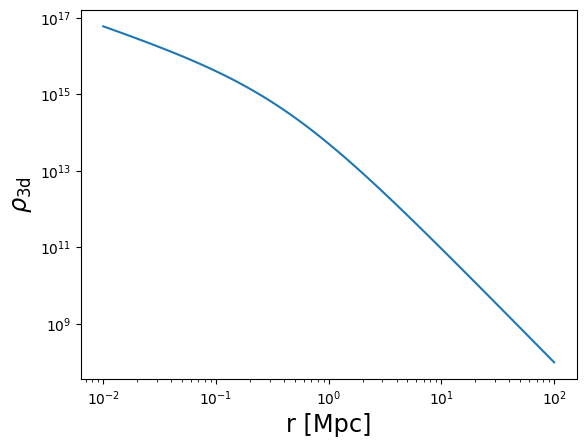

In [8]:
plot_profile(r3d, rho, "$\\rho_{\\rm 3d}$")

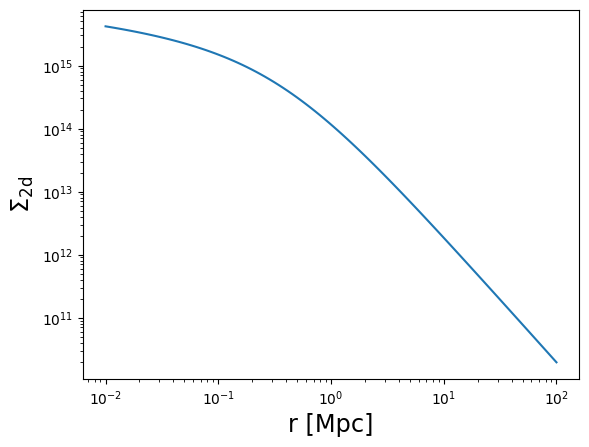

In [9]:
plot_profile(r3d, Sigma, "$\\Sigma_{\\rm 2d}$")

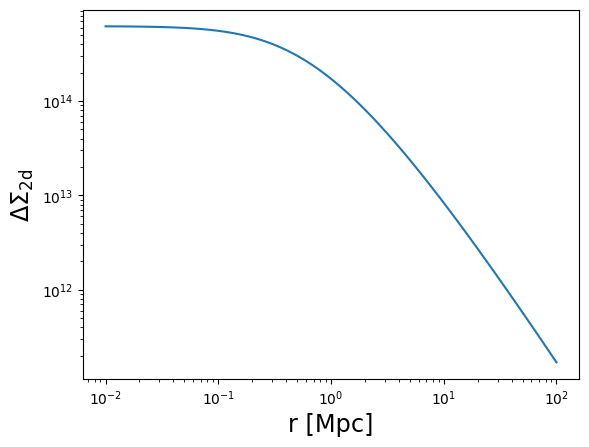

In [10]:
plot_profile(r3d, DeltaSigma, "$\\Delta\\Sigma_{\\rm 2d}$")

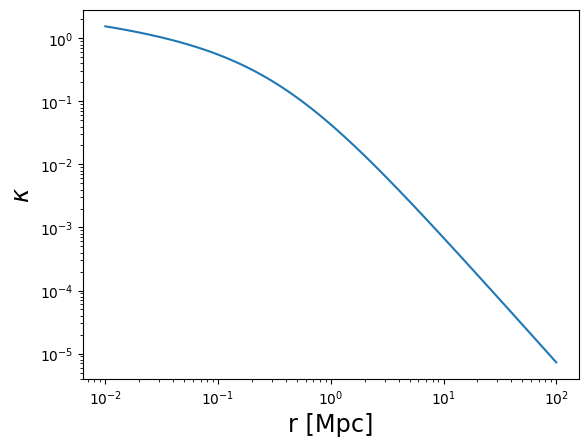

In [11]:
plot_profile(r3d, kappa, "$\\kappa$")

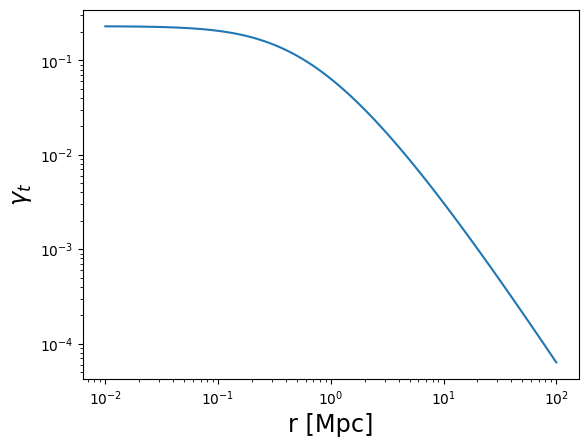

In [12]:
plot_profile(r3d, gammat, "$\\gamma_t$")

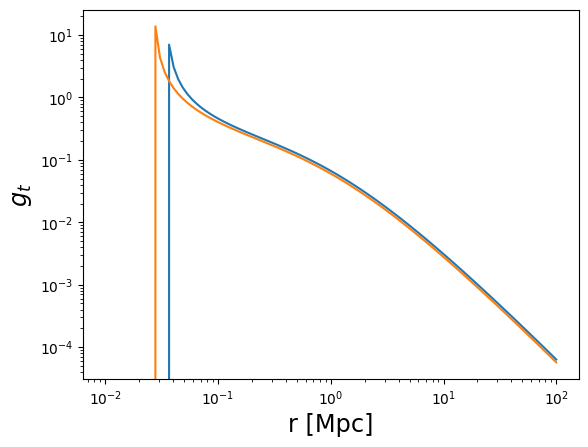

In [13]:
plot_profile(r3d, gt, "$g_t$", label="single plane")
plot_profile(r3d, gt_z, "$g_t$", label="redshift distribution")

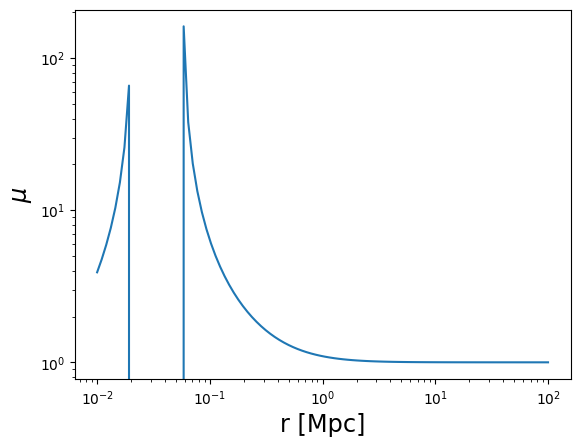

In [14]:
plot_profile(r3d, mu, "$\mu$")

(-3.0, 5.0)

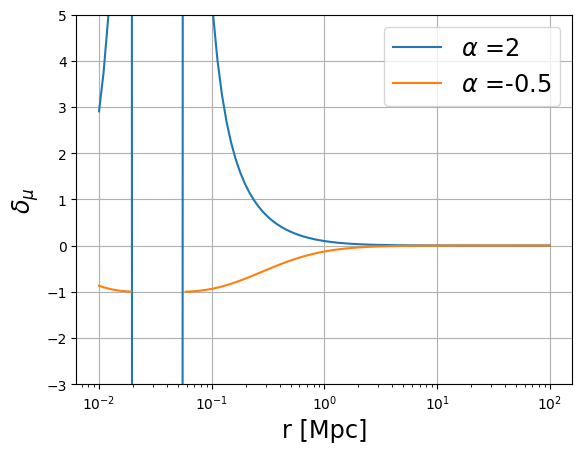

In [15]:
plot_profile(
    r3d, mu_bias[0] - 1, profile_label="$\delta_{\mu}$", label="$\\alpha$ =" + str(alpha[0])
)
plot_profile(r3d, mu_bias[1] - 1, "$\delta_{\mu}$", label="$\\alpha$ =" + str(alpha[1]))

plt.legend(fontsize="xx-large")
plt.yscale("linear")
plt.grid()

plt.ylim(-3, 5)

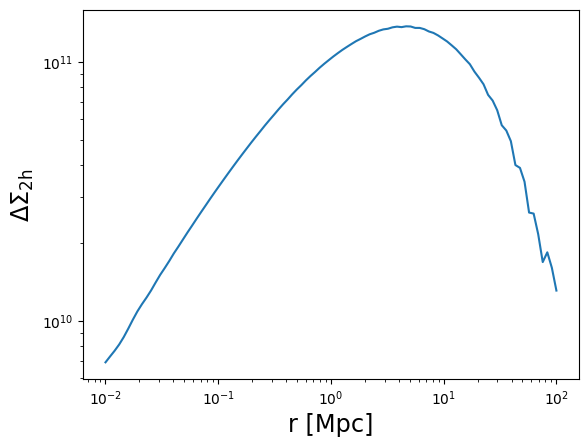

In [16]:
# The 2-halo term excess surface density is currently only implemented for the CCL and NC backends
# An error will be raised if using the CT backend instead

DeltaSigma_2h = moo.eval_excess_surface_density_2h(r3d, z_cl, halobias=0.3)
plot_profile(r3d, DeltaSigma_2h, "$\\Delta\\Sigma_{\\rm 2h}$")

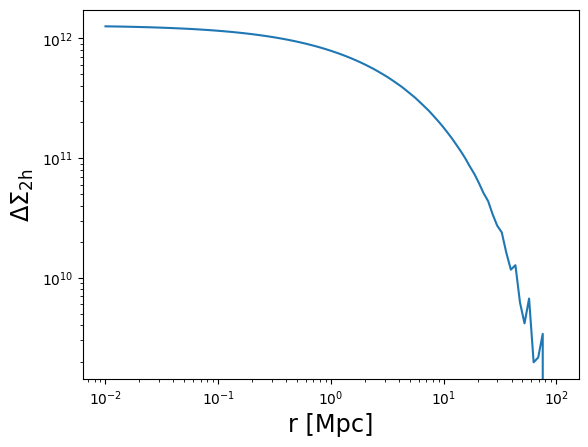

In [17]:
# The 2-halo term excess surface density is currently only implemented for the CCL and NC backends
# An error will be raised if using the CT backend instead

Sigma_2h = moo.eval_surface_density_2h(r3d, z_cl, halobias=0.3)
plot_profile(r3d, Sigma_2h, "$\\Delta\\Sigma_{\\rm 2h}$")

## Side note regarding the Einasto profile (CCL and NC backends only)

The Einasto profile is supported by both the CCL and NumCosmo backends. The value of the slope of the Einasto profile $\alpha_{\rm ein}$ can be defined by the user, using the `set_einasto_alpha` method. If $\alpha_{\rm ein}$ is not provided, both backend revert to a default value for the Einasto slope:
- In CCL, the default Einasto slope depends on cosmology, redshift and halo mass.
- In NumCosmo, the default value is $\alpha=0.25$.

**NB: for CCL, setting a user-defined value for the Einasto slope is only available for CCL version >= 2.6.** Earlier versions only allow the default option.

The verbose option allows to print the value of $\alpha$ that is being used, as follows:

Einasto alpha = 0.17


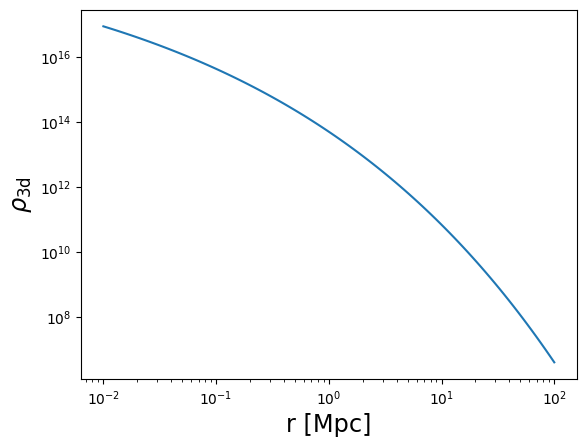

In [18]:
moo_ein = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="einasto")
moo_ein.set_cosmo(cosmo)
moo_ein.set_concentration(4)
moo_ein.set_mass(1.0e15)

# With the NC backend or CCL >=2.6 you may set the slope to the value of your choosing.
# Otherwise, the backend default value will be used
moo_ein.set_einasto_alpha(0.17)

r3d = np.logspace(-2, 2, 100)
rho = moo_ein.eval_3d_density(r3d, z_cl, verbose=True)
plot_profile(r3d, rho, "$\\rho_{\\rm 3d}$")

## Side note regarding the Einasto profile (CCL backend only)

For CCL versions >= 2.8.1.dev73+g86125b08, the surface mass density profile can be calculated with the quad_vec numerial integration in addition to the default FFTLog. This option will increase the precision of the profile at large radii and can be enabled by calling `set_projected_quad(True)`.

Einasto alpha = 0.3713561546989172


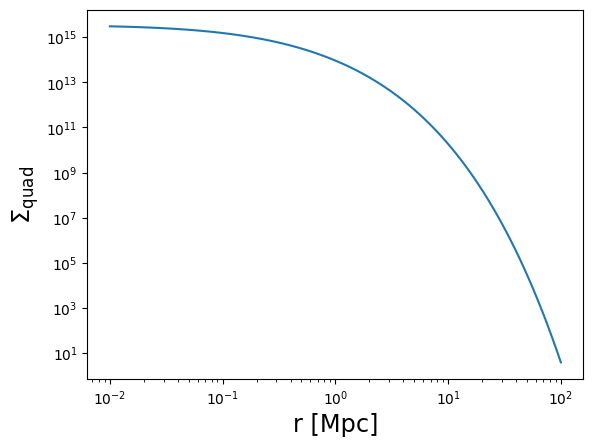

In [19]:
# use quad_vec
moo_ein.set_projected_quad(True)

Sigma_quad = moo_ein.eval_surface_density(r3d, z_cl, verbose=True)

plot_profile(r3d, Sigma_quad, "$\\Sigma_{\\rm quad}$")

Einasto alpha = 0.3713561546989172


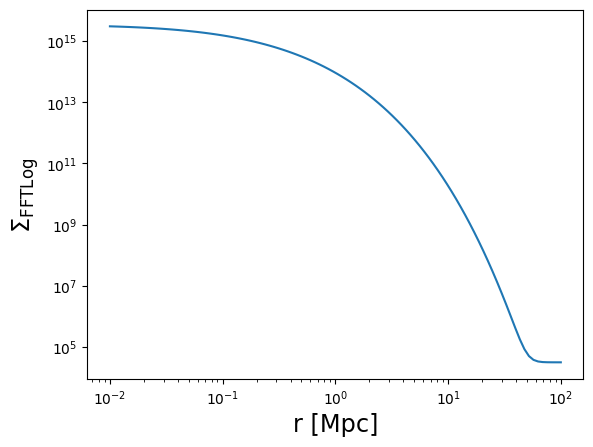

In [20]:
# revert the effect from the previous cell
moo_ein.set_projected_quad(False)

# default behavior
Sigma_FFTLog = moo_ein.eval_surface_density(r3d, z_cl, verbose=True)

plot_profile(r3d, Sigma_FFTLog, "$\\Sigma_{\\rm FFTLog}$")